In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob
import yaml
from PIL import Image

In [3]:


# Path to ZIP file in your Google Drive
zip_path = "/content/drive/MyDrive/Military.zip"
extract_path = "/content/military_object_dataset"

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

print("✅ Extracted to /content")


✅ Extracted to /content


In [4]:
base_dir = "/content/military_object_dataset"
print("Contents of dataset folder:\n")
print(os.listdir(base_dir))


Contents of dataset folder:

['val', 'military_dataset.yaml', 'train', 'test', 'dataset.md']


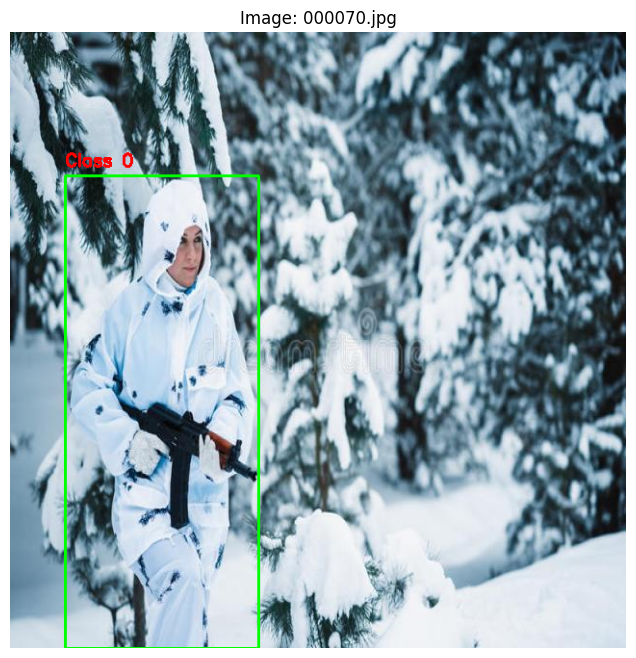

In [5]:
# Paths
image_dir = os.path.join(base_dir, "train/images")
label_dir = os.path.join(base_dir, "train/labels")

# Pick a valid image
image_file = sorted(os.listdir(image_dir))[5]  # You can change index
img_path = os.path.join(image_dir, image_file)
label_path = os.path.join(label_dir, image_file.replace(".jpg", ".txt"))

# Load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw YOLO bounding boxes
h, w, _ = img.shape
with open(label_path, "r") as f:
    for line in f:
        cls, xc, yc, bw, bh = map(float, line.strip().split())
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"Class {int(cls)}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Show image
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.title(f"Image: {image_file}")
plt.show()


In [6]:
# Base directories
image_dir = os.path.join(base_dir, "train/images")
label_dir = os.path.join(base_dir, "train/labels")

# Class ID to name mapping (from project doc)
class_names = {
    0: "camouflage_soldier",
    1: "weapon",
    2: "military_tank",
    3: "military_truck",
    4: "military_vehicle",
    5: "civilian",
    6: "soldier",
    7: "civilian_vehicle",
    8: "trench"
}

# Collect info
image_shapes = []
annotations = []


In [7]:
error_count = 0

print("🔍 Parsing dataset...")
for filename in tqdm(sorted(os.listdir(image_dir))):
    if not filename.lower().endswith(('.jpg', '.png')):
        continue

    img_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt").replace(".png", ".txt"))

    img = cv2.imread(img_path)
    if img is None:
        continue

    h, w = img.shape[:2]
    image_shapes.append((w, h))

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                try:
                    cls = int(parts[0])
                    if len(parts) >= 5:
                        xc, yc, bw, bh = map(float, parts[1:5])
                        annotations.append({
                            "image": filename,
                            "class_id": cls,
                            "class_name": class_names.get(cls, f"Class {cls}"),
                            "width": w,
                            "height": h,
                            "bbox_width_px": bw * w,
                            "bbox_height_px": bh * h,
                            "bbox_area_px": (bw * w) * (bh * h),
                            "bbox_aspect_ratio": (bw * w) / (bh * h + 1e-5)
                        })
                    else:
                        error_count += 1
                        print(f"⚠️ Skipped malformed line in {label_path}: {line.strip()}")
                except Exception as e:
                    error_count += 1
                    print(f"⚠️ Error parsing annotation in {label_path}: {line.strip()} — {e}")

print(f"✅ Done. Parsed {len(annotations)} annotations from {len(image_shapes)} images with {error_count} errors.")

🔍 Parsing dataset...


100%|██████████| 21978/21978 [02:40<00:00, 136.79it/s]

✅ Done. Parsed 43336 annotations from 21978 images with 0 errors.


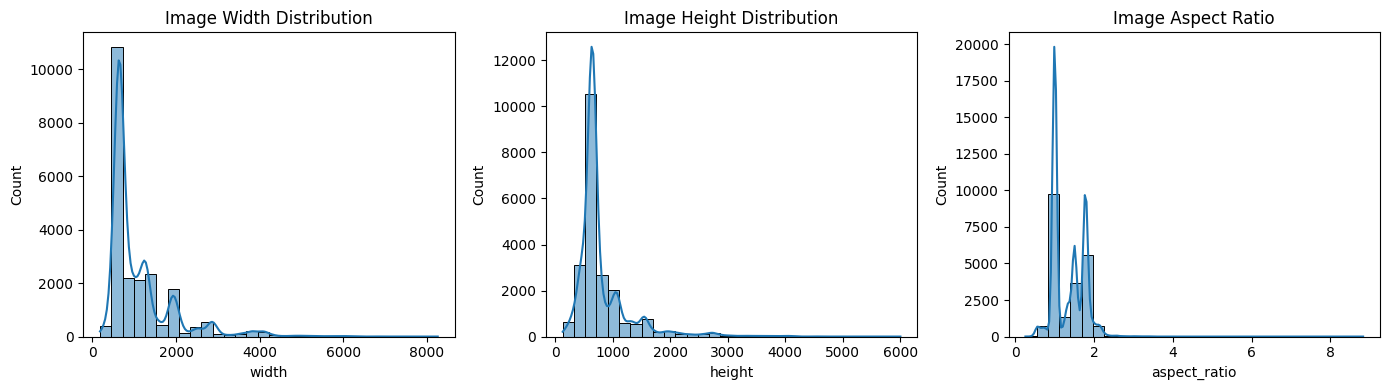

In [8]:
img_df = pd.DataFrame(image_shapes, columns=["width", "height"])
img_df["aspect_ratio"] = img_df["width"] / img_df["height"]

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.histplot(img_df["width"], bins=30, kde=True)
plt.title("Image Width Distribution")

plt.subplot(1, 3, 2)
sns.histplot(img_df["height"], bins=30, kde=True)
plt.title("Image Height Distribution")

plt.subplot(1, 3, 3)
sns.histplot(img_df["aspect_ratio"], bins=30, kde=True)
plt.title("Image Aspect Ratio")

plt.tight_layout()
plt.show()


In [ ]:
 Image Size and Aspect Ratio Insights
📏 Width Distribution
Most images are between 500 and 1500 pixels wide.

A few outliers go up to 8000 px (very large — likely worth resizing).

📐 Height Distribution
Peaks around 600–1000 px.

A few images go up to 6000 px (again, possible outliers).

🖼️ Aspect Ratio
Most are around 1.0–1.5, meaning square to slightly wide.

Some rare long/tall images (aspect ratio > 3–4) — potential issues for YOLO input consistency

SyntaxError: invalid character '📏' (U+1F4CF) (ipython-input-12-3976870843.py, line 2)

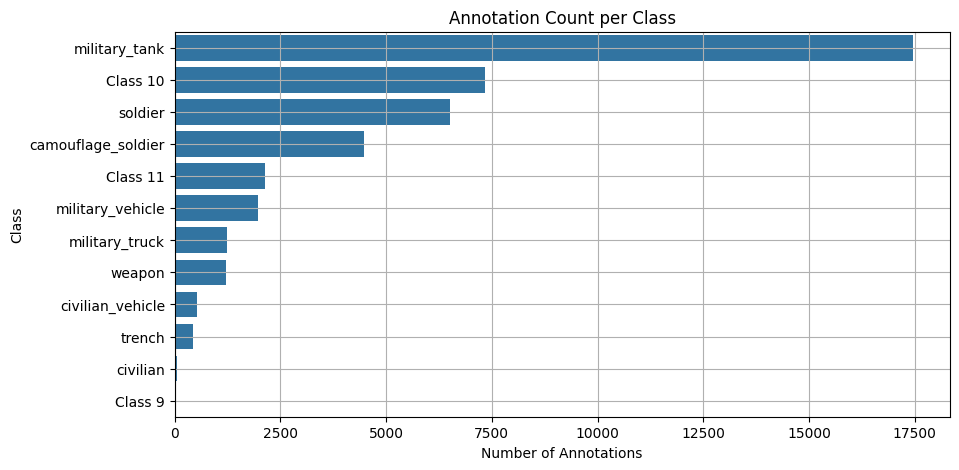

In [9]:
anno_df = pd.DataFrame(annotations)

plt.figure(figsize=(10, 5))
sns.countplot(data=anno_df, y="class_name", order=anno_df["class_name"].value_counts().index)
plt.title("Annotation Count per Class")
plt.xlabel("Number of Annotations")
plt.ylabel("Class")
plt.grid(True)
plt.show()


In [ ]:
Top classes:
military_tank is dominant (~19,000 annotations).

camouflage_soldier, soldier, and even some unknown classes (Class 10, 11) have high counts.

Underrepresented classes:
civilian, trench, civilian_vehicle, military_truck, weapon — all have very few samples.

Class 9, Class 10, Class 11 are unlabeled in your class_names dict

SyntaxError: invalid character '—' (U+2014) (ipython-input-15-3739914606.py, line 7)

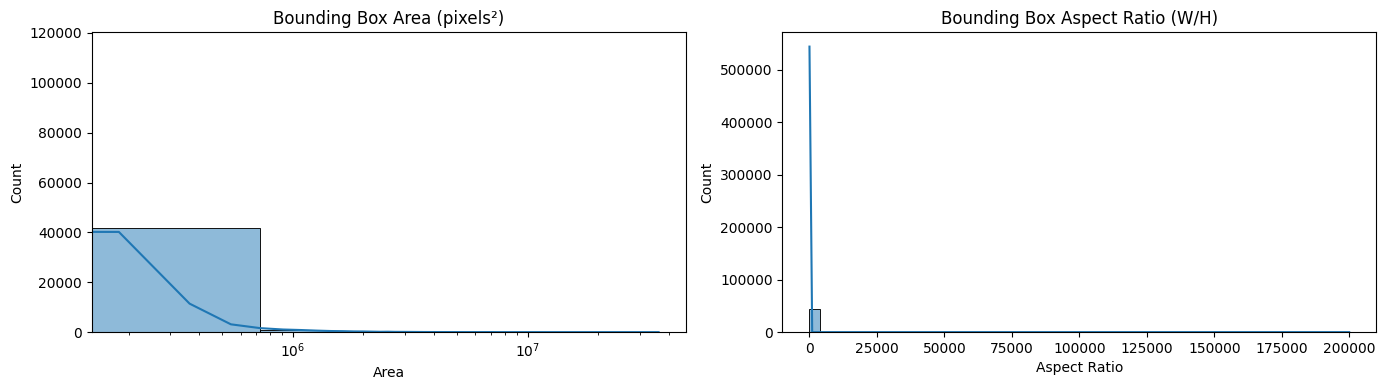

In [10]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.histplot(anno_df["bbox_area_px"], bins=50, kde=True)
plt.title("Bounding Box Area (pixels²)")
plt.xlabel("Area")
plt.xscale("log")

plt.subplot(1, 2, 2)
sns.histplot(anno_df["bbox_aspect_ratio"], bins=50, kde=True)
plt.title("Bounding Box Aspect Ratio (W/H)")
plt.xlabel("Aspect Ratio")

plt.tight_layout()
plt.show()


In [ ]:
Most bounding boxes are very small — clustered at the lower end of the scale.

A log-scaled x-axis helps show this, but we still see a sharp drop after ~10⁵ px².

✅ This confirms you're dealing with small objects, especially for classes like weapon, trench, and possibly civilian.

This plot shows a huge spike near 1–5 (normal).

But there are some outliers with extremely high aspect ratios (tens of thousands!).

That’s likely caused by bad annotations (e.g., width > height by thousands of pixels).

Could also be due to zero-height boxes (division by near-zero height).



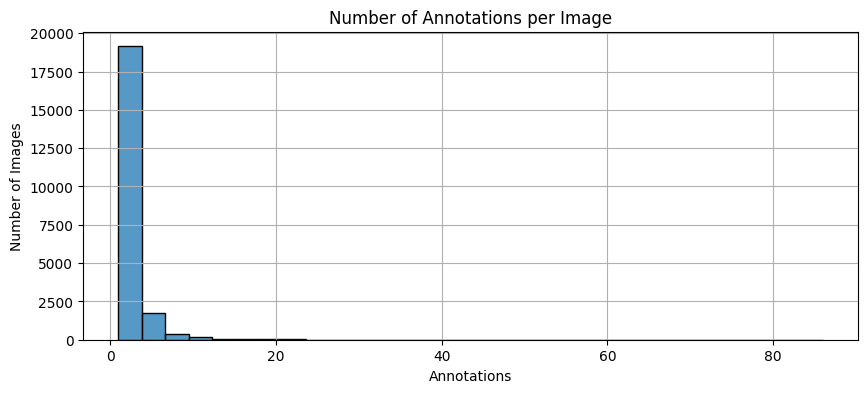

In [11]:
anno_counts = anno_df["image"].value_counts()

plt.figure(figsize=(10, 4))
sns.histplot(anno_counts, bins=30, kde=False)
plt.title("Number of Annotations per Image")
plt.xlabel("Annotations")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()


In [ ]:
Most images (~18,000) contain only 1–2 annotations — indicating sparse labeling per image.

A small tail exists:

Some images have 10–20+ objects

A rare few go beyond 50+ — possibly wide-angle or drone surveillance images.

In [12]:
#Clean Bad Annotations

def clean_yolo_labels(label_dir, image_dir, output_dir, min_area=1024, max_area=1e6, max_ar=10):
    os.makedirs(output_dir, exist_ok=True)
    label_files = glob(os.path.join(label_dir, "*.txt"))

    for label_path in tqdm(label_files, desc="Cleaning annotations"):
        image_file = os.path.basename(label_path).replace(".txt", ".jpg")
        img_path = os.path.join(image_dir, image_file)
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w = img.shape[:2]

        new_lines = []
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls, xc, yc, bw, bh = int(parts[0]), *map(float, parts[1:5])
                    bw_px, bh_px = bw * w, bh * h
                    area = bw_px * bh_px
                    aspect_ratio = bw_px / (bh_px + 1e-5)

                    if (area > min_area and area < max_area) and (aspect_ratio < max_ar):
                        new_lines.append(line)

        # Write cleaned labels
        if new_lines:
            with open(os.path.join(output_dir, os.path.basename(label_path)), "w") as fout:
                fout.writelines(new_lines)

# Run cleaning
clean_yolo_labels(
    label_dir="/content/military_object_dataset/train/labels",
    image_dir="/content/military_object_dataset/train/images",
    output_dir="/content/military_object_dataset/train/labels_cleaned"
)


Cleaning annotations: 100%|██████████| 21978/21978 [02:31<00:00, 145.20it/s]


In [13]:
import os

# Create the missing directory
os.makedirs('/content/military_object_dataset/valid/labels', exist_ok=True)
print("✅ Created missing 'valid/labels' folder.")


✅ Created missing 'valid/labels' folder.


In [14]:
import os

# Folder paths
labels_dirs = [
    "/content/military_object_dataset/train/labels",
    "/content/military_object_dataset/valid/labels"
]

# Allowed class IDs (only these will be retained)
allowed_classes = {'0', '1', '2', '3'}

# Loop through each label directory
for labels_dir in labels_dirs:
    print(f"🔍 Processing label files in: {labels_dir}")

    for filename in os.listdir(labels_dir):
        if filename.endswith(".txt"):
            file_path = os.path.join(labels_dir, filename)

            with open(file_path, 'r') as f:
                lines = f.readlines()

            # Filter only allowed classes
            filtered_lines = [line for line in lines if line.split()[0] in allowed_classes]

            # Overwrite file if there are valid lines
            if filtered_lines:
                with open(file_path, 'w') as f:
                    f.writelines(filtered_lines)
            else:
                # Delete label file if no valid class remains
                os.remove(file_path)

print("✅ Labels cleaned to include only classes 0 to 3.")


🔍 Processing label files in: /content/military_object_dataset/train/labels
🔍 Processing label files in: /content/military_object_dataset/valid/labels
✅ Labels cleaned to include only classes 0 to 3.


In [15]:
import yaml

# Define only the 4 classes you want to train on
class_names = {
    0: "camouflage_soldier",
    1: "weapon",
    2: "military_tank",
    3: "military_truck"
}

# Create the YAML dictionary
data_yaml = {
    "train": "/content/military_object_dataset/train/images",
    "val": "/content/military_object_dataset/valid/images",
    "nc": len(class_names),  # Should be 4
    "names": list(class_names.values())
}

# Write to file
yaml_path = "/content/military_object_dataset/military_dataset.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f)

print(f"✅ Created data.yaml for 4 classes at: {yaml_path}")



✅ Created data.yaml for 4 classes at: /content/military_object_dataset/military_dataset.yaml


In [16]:
#YOLOv8 Training Setup

!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00


In [17]:
import os, shutil, random

# Paths
src_img = "/content/military_object_dataset/train/images"
src_lbl = "/content/military_object_dataset/train/labels_cleaned"
val_img = "/content/military_object_dataset/valid/images"
val_lbl = "/content/military_object_dataset/valid/labels"

os.makedirs(val_img, exist_ok=True)
os.makedirs(val_lbl, exist_ok=True)

# Move 10% of files (with labels)
files = [f for f in os.listdir(src_img) if f.endswith(".jpg")]
val_split = random.sample(files, int(0.1 * len(files)))

moved = 0
for f in val_split:
    label_file = f.replace(".jpg", ".txt")
    label_path = os.path.join(src_lbl, label_file)

    if os.path.exists(label_path):
        shutil.move(os.path.join(src_img, f), os.path.join(val_img, f))
        shutil.move(label_path, os.path.join(val_lbl, label_file))
        moved += 1
    else:
        print(f"⚠️ Skipped {f} — label file missing.")

print(f"✅ Moved {moved} image-label pairs to validation set.")


⚠️ Skipped 000264.jpg — label file missing.
⚠️ Skipped 004017.jpg — label file missing.
⚠️ Skipped 020468.jpg — label file missing.
⚠️ Skipped 021957.jpg — label file missing.
⚠️ Skipped 021741.jpg — label file missing.
⚠️ Skipped 021269.jpg — label file missing.
⚠️ Skipped 021800.jpg — label file missing.
⚠️ Skipped 022530.jpg — label file missing.
⚠️ Skipped 025684.jpg — label file missing.
⚠️ Skipped 002432.jpg — label file missing.
⚠️ Skipped 026155.jpg — label file missing.
⚠️ Skipped 004367.jpg — label file missing.
⚠️ Skipped 007013.jpg — label file missing.
⚠️ Skipped 019608.jpg — label file missing.
⚠️ Skipped 021279.jpg — label file missing.
⚠️ Skipped 026055.jpg — label file missing.
⚠️ Skipped 005378.jpg — label file missing.
⚠️ Skipped 020501.jpg — label file missing.
⚠️ Skipped 002123.jpg — label file missing.
⚠️ Skipped 019072.jpg — label file missing.
⚠️ Skipped 018775.jpg — label file missing.
⚠️ Skipped 012492.jpg — label file missing.
⚠️ Skipped 004385.jpg — label fi

In [18]:
import yaml

yaml_path = "/content/military_object_dataset/military_dataset.yaml"

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

data["val"] = "/content/military_object_dataset/valid/images"

with open(yaml_path, "w") as f:
    yaml.dump(data, f)

print("✅ Updated `military_dataset.yaml` to use the new validation set.")


✅ Updated `military_dataset.yaml` to use the new validation set.


In [19]:
import os

# Directory containing label .txt files
label_dirs = [
    "/content/military_object_dataset/train/labels",
    "/content/military_object_dataset/valid/labels"
]

for label_dir in label_dirs:
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            path = os.path.join(label_dir, file)
            with open(path, "r") as f:
                lines = f.readlines()
            # Keep only lines with class IDs 0 to 3
            cleaned = [line for line in lines if int(line.split()[0]) <= 3]
            with open(path, "w") as f:
                f.writelines(cleaned)
print("✅ Cleaned labels to keep only class IDs 0–3.")


✅ Cleaned labels to keep only class IDs 0–3.


In [ ]:
!yolo task=detect mode=train model=yolov8n.pt epochs=30 imgsz=640 batch=16 \
data=/content/military_object_dataset/military_dataset.yaml \
name=military_detection project=/content/drive/MyDrive/yolo_runs \
save_period=1 plots=True

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/military_object_dataset/military_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=military_detection4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

In [ ]:
!yolo task=detect mode=train model=/content/drive/MyDrive/yolo_runs/military_detection4/weights/last.pt \
data=/content/military_object_dataset/military_dataset.yaml \
epochs=30 imgsz=640 batch=16 \
name=military_detection_continue \
project=/content/drive/MyDrive/yolo_runs \
save_period=1 plots=True device=0



Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/military_object_dataset/military_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/yolo_runs/military_detection4/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=military_detection_continue, nbs=64, nms=False, opset=None, optimize=Fal

In [ ]:
!yolo task=detect mode=train \
model=/content/drive/MyDrive/yolo_runs/military_detection_continue/weights/best.pt \
data=/content/military_object_dataset/military_dataset.yaml \
epochs=20 lr0=0.0005 freeze=10 imgsz=640 batch=16 \
name=military_detection_finetune project=/content/drive/MyDrive/yolo_runs \
save_period=1 plots=True device=0


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/military_object_dataset/military_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, k

In [ ]:
!ls /content/drive/MyDrive/yolo_runs/military_detection4/weights/



best.pt     epoch14.pt	epoch1.pt   epoch25.pt	epoch3.pt  epoch9.pt
epoch0.pt   epoch15.pt	epoch20.pt  epoch26.pt	epoch4.pt  last.pt
epoch10.pt  epoch16.pt	epoch21.pt  epoch27.pt	epoch5.pt
epoch11.pt  epoch17.pt	epoch22.pt  epoch28.pt	epoch6.pt
epoch12.pt  epoch18.pt	epoch23.pt  epoch29.pt	epoch7.pt
epoch13.pt  epoch19.pt	epoch24.pt  epoch2.pt	epoch8.pt


In [ ]:
!yolo task=detect mode=train \
model=/content/drive/MyDrive/yolo_runs/military_detection_finetune/weights/best.pt \
data=/content/military_object_dataset/military_dataset.yaml \
epochs=15 lr0=0.00025 freeze=0 imgsz=640 batch=16 \
name=military_detection_full_finetune project=/content/drive/MyDrive/yolo_runs \
save_period=1 plots=True device=0


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/military_object_dataset/military_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00025, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/yolo_runs/military_detection_finetune/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=military_detection_full_finetune, nbs=64, nms=False, opset=None,

In [21]:

# Update this path to any one of your run folders
csv_path = "/content/drive/MyDrive/yolo_runs/military_detection_full_finetune/results.csv"
df = pd.read_csv(csv_path)

print("📄 Available columns:")
print(df.columns.tolist())


📄 Available columns:
['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


📊 Model Comparison Summary:
                           Run Name  Epochs    mAP50  mAP50-95
2       military_detection_finetune      20  0.91510   0.68654
3  military_detection_full_finetune      15  0.89977   0.65999
1       military_detection_continue      30  0.83542   0.58832
0               military_detection4      30  0.81523   0.56661


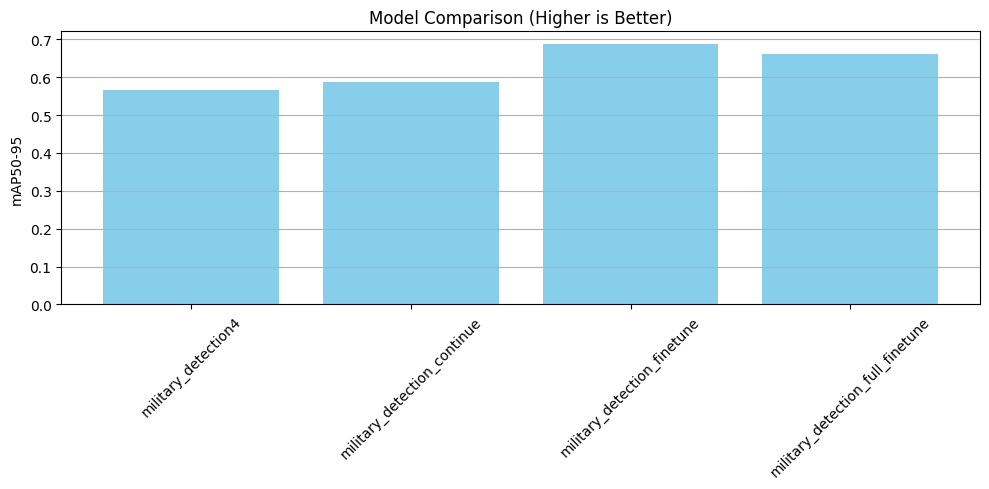

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# List your YOLOv8 runs (update paths if needed)
run_dirs = [
    "/content/drive/MyDrive/yolo_runs/military_detection4",
    "/content/drive/MyDrive/yolo_runs/military_detection_continue",
    "/content/drive/MyDrive/yolo_runs/military_detection_finetune",
    "/content/drive/MyDrive/yolo_runs/military_detection_full_finetune"
]

results = []

for run in run_dirs:
    csv_path = os.path.join(run, "results.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        last_row = df.iloc[-1]
        results.append({
            "Run Name": os.path.basename(run),
            "Epochs": len(df),
            "mAP50": last_row["metrics/mAP50(B)"],
            "mAP50-95": last_row["metrics/mAP50-95(B)"]
        })
    else:
        print(f"⚠️ No results.csv found in: {run}")

# Create DataFrame
compare_df = pd.DataFrame(results)

# Display table
print("📊 Model Comparison Summary:")
print(compare_df.sort_values("mAP50-95", ascending=False))

# Optional: Plot
plt.figure(figsize=(10, 5))
plt.bar(compare_df["Run Name"], compare_df["mAP50-95"], color="skyblue")
plt.ylabel("mAP50-95")
plt.title("Model Comparison (Higher is Better)")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [27]:
!yolo task=detect mode=predict \
model=/content/drive/MyDrive/yolo_runs/military_detection_finetune/weights/best.pt \
source=/content/military_object_dataset/test/images \
conf=0.25 \
save=True


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs

image 1/1396 /content/military_object_dataset/test/images/000001.jpg: 640x640 1 camouflage_soldier, 8.5ms
image 2/1396 /content/military_object_dataset/test/images/000002.jpg: 640x640 1 camouflage_soldier, 7.5ms
image 3/1396 /content/military_object_dataset/test/images/000003.jpg: 640x640 1 camouflage_soldier, 7.4ms
image 4/1396 /content/military_object_dataset/test/images/000004.jpg: 640x640 1 camouflage_soldier, 7.3ms
image 5/1396 /content/military_object_dataset/test/images/000005.jpg: 640x640 (no detections), 7.4ms
image 6/1396 /content/military_object_dataset/test/images/000006.jpg: 640x640 1 camouflage_soldier, 7.4ms
image 7/1396 /content/military_object_dataset/test/images/000007.jpg: 640x640 1 camouflage_soldier, 7.4ms
image 8/1396 /content/military_object_dataset/test/images/000008.jpg: 640x640 2 camouflage_soldiers

In [25]:
import os

test_dir = "/content/military_object_dataset/test/images"
print("Exists:", os.path.exists(test_dir))
print("Files:", os.listdir(test_dir))


Exists: True
Files: ['002849.jpg', '017069.jpg', '013567.jpg', '013633.jpg', '013582.jpg', '002921.jpg', '008809.jpg', '002926.jpg', '017176.jpg', '023357.jpg', '023742.jpg', '013391.jpg', '008916.jpg', '023327.jpg', '008719.jpg', '008907.jpg', '000051.jpg', '008754.jpg', '013583.jpg', '008886.jpg', '023710.jpg', '023398.jpg', '017115.jpg', '008697.jpg', '013554.jpg', '013511.jpg', '013406.jpg', '017077.jpg', '006032.jpg', '002956.jpg', '003010.jpg', '000064.jpg', '008739.jpg', '023747.jpg', '017043.jpg', '023728.jpg', '008730.jpg', '023393.jpg', '008877.jpg', '023391.jpg', '023732.jpg', '002840.jpg', '017044.jpg', '013541.jpg', '023366.jpg', '023355.jpg', '023400.jpg', '017128.jpg', '017074.jpg', '023750.jpg', '002920.jpg', '008800.jpg', '002994.jpg', '013612.jpg', '002976.jpg', '023377.jpg', '000024.jpg', '008661.jpg', '003025.jpg', '017196.jpg', '017108.jpg', '008851.jpg', '023406.jpg', '008882.jpg', '017106.jpg', '013670.jpg', '006025.jpg', '023320.jpg', '002931.jpg', '023401.jpg',

In [31]:
import os

predict_dir = "/content/runs/detect/predict"
detected = len(os.listdir(predict_dir))
total = 1396  # total test images
print(f"✅ Detected objects in {detected}/{total} images ({detected/total*100:.2f}%)")


✅ Detected objects in 1396/1396 images (100.00%)
